In [36]:
from __future__ import division
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# 1

In [1]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_150627.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.0M    0 24.0M    0     0  2376k      0 --:--:--  0:00:10 --:--:-- 4909k


In [2]:
!ls

02_Will.ipynb                    all_stns_by_weekdayAllWeek.png
2NY_BIG Annotated.jpg            all_turnstiles.py
Assumptions and Challenges.pdf   busiest.csv
CreativeCloudInstaller.dmg       challenge_solutions.ipynb
Exploratory Analysis.ipynb       data
Methodology.ipynb                mta_challenge_3.ipynb
NY_BIG Annotated.jpg             three_Benson_solutions.ipynb
README.md                        top_20_stations.tsv
all_stns_by_weekday1.png         turnstile_150627.txt
all_stns_by_weekday2.png         turnstiles.py
all_stns_by_weekday3.png         turnstiles.py.orig
all_stns_by_weekdayAll.png       turnstiles.pyc
all_stns_by_weekdayAllWeek-1.png


In [4]:
%%time
import csv
with open('turnstile_150627.txt') as f:
    reader = csv.reader(f)
    rows = [[cell.strip() for cell in row] for row in reader]

CPU times: user 962 ms, sys: 76.1 ms, total: 1.04 s
Wall time: 1.04 s


In [5]:
rows.pop(0)

['C/A',
 'UNIT',
 'SCP',
 'STATION',
 'LINENAME',
 'DIVISION',
 'DATE',
 'TIME',
 'DESC',
 'ENTRIES',
 'EXITS']

In [7]:
raw_readings = {}
for row in rows:
    raw_readings.setdefault(tuple(row[:4]), []).append((row[4:]))

#  2

In [11]:
from datetime import datetime

In [12]:
datetime_cumulative = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in raw_readings.items()}

In [ ]:
datetime_count_times = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1],
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}

In [15]:
all_counts = [count for rows in datetime_count_times.values() for _, count, _ in rows]

In [16]:
all_counts.sort()
print all_counts[-50:]


[2428, 2443, 2444, 2447, 2448, 2455, 2456, 2459, 2473, 2474, 2487, 2492, 2514, 2521, 2536, 2548, 2552, 2554, 2558, 2567, 2569, 2579, 2602, 2612, 2621, 2622, 2630, 2630, 2644, 2656, 2670, 2671, 2692, 2728, 2731, 2757, 2765, 2804, 2844, 2848, 2920, 2926, 2926, 3488, 87577, 130932, 131711, 131792, 531430, 117440499]


In [18]:
print all_counts[:50]


[-1208464910, -8664797, -7691983, -1958436, -1283643, -531174, -131370, -131215, -130432, -87562, -73467, -65355, -2545, -1929, -1852, -1782, -1720, -1703, -1687, -1677, -1662, -1659, -1645, -1608, -1572, -1571, -1553, -1543, -1533, -1524, -1492, -1484, -1482, -1455, -1410, -1404, -1403, -1402, -1401, -1397, -1378, -1376, -1362, -1357, -1345, -1339, -1332, -1326, -1323, -1311]


In [19]:
from collections import Counter
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_count_times.values()
             for _, _, duration in rows]
print Counter(all_times).most_common(10)

[(4.0, 172791), (4.2, 10460), (8.0, 189), (4.433333333333334, 161), (0.02222222222222222, 80), (0.02277777777777778, 64), (0.022500000000000003, 55), (0.02777777777777778, 26), (0.03611111111111111, 24), (3.963888888888889, 24)]


In [20]:
datetime_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_count_times.items()}

In [24]:
all_good_counts = [count for rows in datetime_counts.values() for _, count in rows]
print len(all_good_counts) / len(all_counts)

0.99415985405


In [27]:
all_good_counts.sort()
print all_good_counts[-5:]

[2848, 2920, 2926, 2926, 3488]


# 3

In [28]:
day_counts = {}
for turnstile, rows in datetime_counts.items():
    by_day = {}
    for time, count in rows:
        day = time.date()
        by_day[day] = by_day.get(day, 0) + count
    day_counts[turnstile] = sorted(by_day.items())

In [29]:
day_counts.items()[0]


(('A030', 'R083', '01-06-00', '23 ST-5 AVE'),
 [(datetime.date(2015, 6, 20), 1008),
  (datetime.date(2015, 6, 21), 767),
  (datetime.date(2015, 6, 22), 2438),
  (datetime.date(2015, 6, 23), 2651),
  (datetime.date(2015, 6, 24), 2680),
  (datetime.date(2015, 6, 25), 2683),
  (datetime.date(2015, 6, 26), 1951)])

# 4, 5 ,6, and 7

Note that I am merging the turnstiles here because it makes more sense for me to do it here rather than print time series for individual turnstiles.

In [80]:
import pandas as pd
cols = ['ca', 'unit', 'scp', 'station', 
            'linename', 'division', 'date', 'time', 
            'desc', 'entries', 'exits']
df = pd.read_csv('turnstile_150627.txt', names=cols, header=True)

In [100]:
df.head()

,station,datetime,date,time,entries,exits
1,"(LEXINGTON AVE, NQR456)",2015-06-20 08:00:00,06/20/2015,08:00:00,18,29
2,"(LEXINGTON AVE, NQR456)",2015-06-20 12:00:00,06/20/2015,12:00:00,102,97
3,"(LEXINGTON AVE, NQR456)",2015-06-20 16:00:00,06/20/2015,16:00:00,216,70
4,"(LEXINGTON AVE, NQR456)",2015-06-20 20:00:00,06/20/2015,20:00:00,364,61
5,"(LEXINGTON AVE, NQR456)",2015-06-21 00:00:00,06/21/2015,00:00:00,159,38


In [81]:
from turnstiles import makeCols 

In [82]:
df = makeCols(df)

In [84]:
dates = pd.DatetimeIndex(df.datetime)
time_station_totals = df.groupby(['station', dates.date]).exits.sum()

In [ ]:
# Dealing with indices is annoying
time_station_totals = time_station_totals.reset_index()

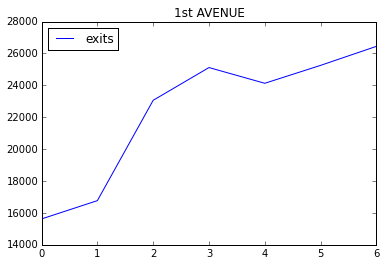

In [99]:
time_station_totals[:7].plot()
plt.title("1st AVENUE")

# 8

In [109]:
dates = pd.DatetimeIndex(time_station_totals.level_1)
day_of_week_totals = time_station_totals.groupby([dates.dayofweek]).exits.sum()

In [110]:
day_of_week_totals

0    4360853
1    4566817
2    4605372
3    4649481
4    4579521
5    2341996
6    2311034
Name: exits, dtype: float64

So we can see here that the total subway ridership decreases substantially during the weekdays.

# 9

In [111]:
df

,station,datetime,date,time,entries,exits
1,"(LEXINGTON AVE, NQR456)",2015-06-20 08:00:00,06/20/2015,08:00:00,18,29
2,"(LEXINGTON AVE, NQR456)",2015-06-20 12:00:00,06/20/2015,12:00:00,102,97
3,"(LEXINGTON AVE, NQR456)",2015-06-20 16:00:00,06/20/2015,16:00:00,216,70
4,"(LEXINGTON AVE, NQR456)",2015-06-20 20:00:00,06/20/2015,20:00:00,364,61
5,"(LEXINGTON AVE, NQR456)",2015-06-21 00:00:00,06/21/2015,00:00:00,159,38
6,"(LEXINGTON AVE, NQR456)",2015-06-21 04:00:00,06/21/2015,04:00:00,26,7
7,"(LEXINGTON AVE, NQR456)",2015-06-21 08:00:00,06/21/2015,08:00:00,26,18
8,"(LEXINGTON AVE, NQR456)",2015-06-21 12:00:00,06/21/2015,12:00:00,72,54
9,"(LEXINGTON AVE, NQR456)",2015-06-21 16:00:00,06/21/2015,16:00:00,219,57
10,"(LEXINGTON AVE, NQR456)",2015-06-21 20:00:00,06/21/2015,20:00:00,233,44


In [121]:
dates = pd.DatetimeIndex(df.datetime)
total_per_station = df.groupby('station').sum()

In [124]:
total_per_station.head()

,entries,exits
station,,
"(1 AVE, L)",150372,156406
"(103 ST, 1)",84286,38634
"(103 ST, 6)",47863,70490
"(103 ST, BC)",29319,19095
"(103 ST-CORONA, 7)",122220,76700


# 10

I plot the 15 most trafficked stations

In [138]:
curated_total_per_station = total_per_station.sort(columns=['exits'], 
                                                   ascending=False)[:15]

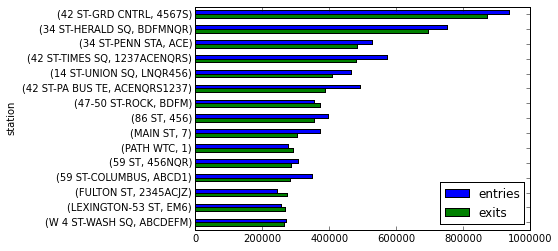

In [139]:
curated_total_per_station.plot(kind='barh')
plt.gca().invert_yaxis()